In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [15]:
from __future__ import print_function

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from deepviz.guided_backprop import GuidedBackprop
# from sklearn.cross_validation import train_test_split
from sklearn.metrics.ranking import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

try:
    import keras

    import keras.backend as K
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation
    from keras.optimizers import RMSprop
    from keras.optimizers import Adam
    from keras.callbacks import LambdaCallback, ReduceLROnPlateau, ModelCheckpoint
    from keras.layers.core import Lambda
    from keras.losses import categorical_crossentropy
    import tensorflow as tf
    from keras import regularizers
except:
    print("Keras not found")

np.random.seed(42)


def my_basename(path):
    return os.path.splitext(os.path.split(path)[1])[0]

file_dir=r'C:/Users/M-RAM/PycharmProjects/InternshipNaturalis/github_trait_geo_diverse_dl/trait-geo-diverse-dl'

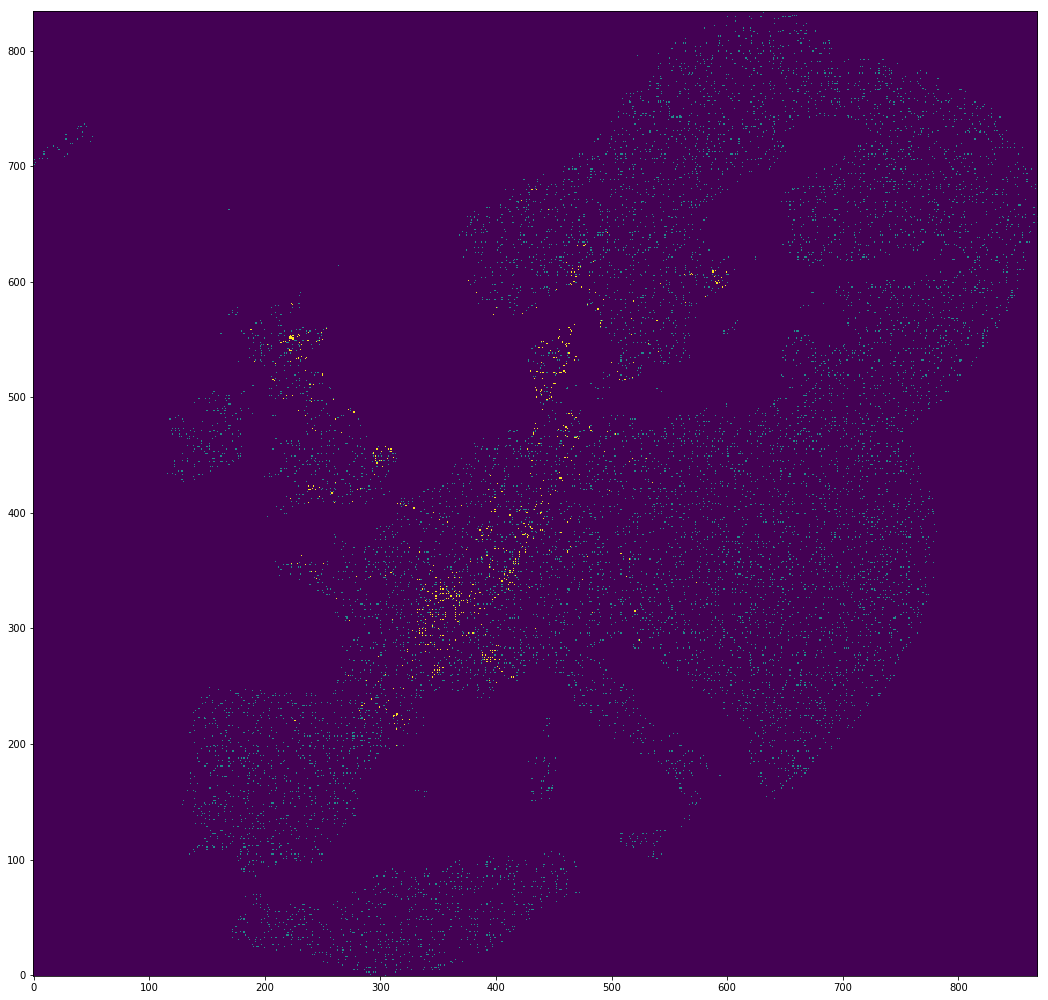

651
9955


KeyboardInterrupt: 

In [27]:


def main():
    table = pd.read_csv(file_dir+"/data/capriolus_trial/Capriolus_capriolus_env_dataframe.csv")

   # table=table.loc[:1500]
    # at 40 degrees latitude
    bin_size_km = 5
    one_degree_latitude_km = 111.03  # http://www.longitudestore.com/how-big-is-one-gps-degree.html
    one_degree_longitude_km = 85.39
    step_latitude = 1. / one_degree_latitude_km * bin_size_km
    step_longitude = 1. / one_degree_longitude_km * bin_size_km
    #print("step_latitude, step_longitude", step_latitude, step_longitude)
    
    # remove spaces from column names
    for column in table.columns:
        table[column.strip()] = table[column]
        if column.strip() != column:
            del table[column]
    #print(table.columns)
    #print(table.decimal_latitude.min(), table.decimal_latitude.max())

    latitude_min = table.decimal_latitude.min()
    longitude_min = table.decimal_longitude.min()
    table.decimal_latitude = table.decimal_latitude.apply(lambda x: (x - latitude_min) // step_latitude)
    table.decimal_longitude = table.decimal_longitude.apply(lambda x: (x - longitude_min) // step_longitude)
    table.decimal_latitude = table.decimal_latitude.astype(int)
    table.decimal_longitude = table.decimal_longitude.astype(int)
    im = np.ones((table.decimal_latitude.max() + 1, table.decimal_longitude.max() + 1)) * 3
    for _, row in table.iterrows():
        im[int(row.decimal_latitude), int(row.decimal_longitude)] = row["present/pseudo_absent"] * 128 + 128
    plt.figure(figsize=(18, 18))
    plt.imshow(im, cmap="viridis")
    plt.gca().invert_yaxis()
    plt.show()

    #realistic_min_values_per_band = {}
    #for column in table.columns:
     #   if "band" in column:
            # print(column, scoreatpercentile(table[column], 0.99))
      #      column_values = table[column].values
       #     realistic_min_values_per_band[column] = column_values[np.where(column_values > -9999.0)].min()

    # make feature vector
    band_columns = [column for column in table.columns[8:]]
    X = []
    y = []
    for _, row in table.iterrows():
        x = row[band_columns].values
        if (np.any(x <= -9999.0)):  # in sea?
            continue
        # print(row["present/pseudo_absent"], np.where(x <= -9999.0)[0])
        x = x.tolist()
        x.append(row["present/pseudo_absent"])
        X.append(x)

    df = pd.DataFrame(data=X, columns=band_columns + ["presence"])
    df.to_csv("filtered.csv", index=None)
    
    print(len(df[df["presence"]==1]))
    print(len(df[df["presence"]==0]))
    
    #Scale feature values
    for column in df.columns[:-1]:
        #if "band" in column:
        std_dev = np.std(df[column])
        mean_ = np.mean(df[column])
        df[column] = df[column].apply(lambda x: (x - mean_) / std_dev)
    df.to_csv("normalized.csv", index=None)

    X = []
    y = []
    band_columns = [column for column in df.columns[:-1]]
    #print(band_columns)

    for _, row in df.iterrows():
        X.append(row[band_columns].values.tolist())
        y.append([1 - row["presence"], row["presence"]])
    #print(y)
    X = np.vstack(X)
    y = np.vstack(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
   #print(y_train,y_test)
    #
    batch_size = 50
    num_classes = 2
    epochs = 250

    num_inputs = X.shape[1]  # number of features

    reducelr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-8,
                                          verbose=1)

    model = Sequential()
    layer_1 = Dense(200, activation='relu', input_shape=(num_inputs,),
                  #kernel_regularizer=regularizers.l1(0.01),
                  #activity_regularizer=regularizers.l1(0.002)
                  )
    layer_2 = Dense(100, activation='relu', input_shape=(num_inputs,),
              #kernel_regularizer=regularizers.l1(0.01),
              #activity_regularizer=regularizers.l1(0.002)
              )
    
    layer_3 = Dense(50, activation='relu', input_shape=(num_inputs,),
          #kernel_regularizer=regularizers.l1(0.01),
         #activity_regularizer=regularizers.l1(0.002)
          )
    model.add(layer_1)
    model.add(layer_2)
    model.add(layer_3)
    #model.add(Dropout(0.5))
    
    # model.add(Lambda(lambda x: K.dropout(x, level=0.5)))
    # model.add(Dense(512, activation='relu',
    #             # kernel_regularizer=regularizers.l2(0.01),
    #             # activity_regularizer=regularizers.l1(0.01)
    #                 ))
    # model.add(Dropout(0.5))
    # model.add(Lambda(lambda x: K.dropout(x, level=0.5)))
    out_layer = Dense(num_classes, activation=None)
    model.add(out_layer)
    model.add(Activation("softmax"))
    
    model.summary()

    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(lr=0.00001), #, rho=0.9, epsilon=1e-08, decay=0.0),
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_test, y_test),
                        callbacks=[], #reducelr_callback],
                        shuffle=True,
                        class_weight={
                            0: 0.07,
                            1: 0.93,
                        }
                        )
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    predictions = model.predict(X_test)
    print("AUC", roc_auc_score(y_test[:, 1], predictions[:, 1]))
    fpr, tpr, thresholds = roc_curve(y_test[:, 1], predictions[:, 1])
    plt.plot(fpr, tpr)
    plt.show()

    for i, xy in enumerate(zip(fpr, tpr)):
        plt.gca().annotate(str(thresholds[i]), xy=xy, textcoords='data')

    plt.show()

    
if __name__ == "__main__":
    main()
